# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

# category_encoders for improved OneHotEncoder
import category_encoders as ce

# sklearn_pandas for imputer of categorical features
#from sklearn_pandas import CategoricalImputer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("data"))

# Any results you write to the current directory are saved as output.

['desktop.ini', 'test.csv', 'train.csv']


# Auxiliary functions and classes

In [2]:
class TypeSelector(BaseEstimator, TransformerMixin):
    """ A Dataframe transformer that selects columns by type """
    
    def __init__(self, dtype):
        # examples: 'bool', np.numpy, 'object', 'category'
        self.dtype = dtype

    def fit(self, X, *_):
        """ Do nothing operation
        Returns
        ----------
        self : object
        """
        return self

    def transform(self, X, *_):
        """ Returns the columns of a given type.

        Parameters
        ----------
        X : pandas DataFrame
    
        Returns
        ----------
        X_sel : pandas DataFrame
        """

        assert isinstance(X, pd.DataFrame)
        X_sel = X.select_dtypes(include=[self.dtype]).copy()        
        return X_sel
    

class FillMissing(BaseEstimator, TransformerMixin): 
    """ A Dataframe transformer that fills missing values """
    def __init__(self, drop_first=True):
        self.drop_first = drop_first

    def fit(self, X, **fitparams):
        """ Do nothing operation
        Returns
        ----------
        self : object
        """
        return self

    def transform(self, X, **transformparams):
        """ Returns a dummy variable encoded version of a DataFrame
            Note: by default, it drops the first feature.
        Parameters
        ----------
        X : pandas DataFrame

        Returns
        ----------
        X_dummies : pandas DataFrame
        """

        assert isinstance(X, pd.DataFrame)
        #X_missing = X.fillna('missing')
        X_missing = X.apply(lambda column: column.fillna(column.mode()[0]), axis = 0)
        return X_missing
    

class DropColumns(BaseEstimator, TransformerMixin): 
    """ A Dataframe transformer that drop columns """
    def __init__(self, columns=[]):
            self.columns = columns

    def fit(self, X, **fitparams):
        """ Do nothing operation
        Returns
        ----------
        self : object
        """
        return self

    def transform(self, X, **transformparams):
        """ Returns a dataframe without the specified columns.
        Parameters
        ----------
        X : pandas DataFrame

        Returns
        ----------
        X_drop : pandas DataFrame
        """

        assert isinstance(X, pd.DataFrame)
        X_drop = X.copy()
        X_drop = X_drop.drop(self.columns, axis=1, errors='ignore')
        
        return X_drop
    

class FeatureEngineering(BaseEstimator, TransformerMixin): 
    """ A Dataframe transformer that drop columns """
    #def __init__(self, columns=[]):
    #        self.columns = columns

    def fit(self, X, **fitparams):
        """ Do nothing operation
        Returns
        ----------
        self : object
        """
        return self

    def transform(self, X, **transformparams):
        """ Returns a dataframe with the feature engineering.
        Parameters
        ----------
        X : pandas DataFrame

        Returns
        ----------
        X_output : pandas DataFrame
        """

        assert isinstance(X, pd.DataFrame)
        X_fe = X.copy()
        
        X_fe['2ndFlr'] = X_fe['2ndFlrSF'] > 0
        X_fe = X_fe.drop('2ndFlrSF', axis=1)
        
        return X_fe

# Read data

In [3]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [4]:
#df_train.head()

In [5]:
#df_train.info()

In [6]:
#df_test.info()

## Exploratory Analysis

Correlation matrix including the target

In [7]:
corrmat = df_train.corr()
#plt.figure(figsize=(12,9))
#sns.heatmap(corrmat, vmax = 0.8, cmap="RdBu_r");

Correlation matrix for the features (except 'Id')

In [8]:
corrmat = df_train.drop(columns=['Id', 'SalePrice']).corr()
#plt.figure(figsize=(12,9))
#sns.heatmap(corrmat, vmax = 0.8, cmap="RdBu_r");

Correlation matrix for features with the most correlated features

In [9]:
corrmat = df_train.drop(columns=['Id', 'SalePrice']).corr()
corrmat_mask = corrmat.abs() > 0.5
corrmat = corrmat[corrmat_mask].dropna(thresh=2).dropna(axis=1, thresh=2)
#plt.figure(figsize=(11,8))
#sns.heatmap(corrmat, cmap="RdBu_r");

In [10]:
#corrmat.loc['GarageCars','GarageArea']

In [11]:
#corrmat.loc['TotalBsmtSF','1stFlrSF']

In [12]:
#corrmat.loc['GrLivArea','TotRmsAbvGrd']

In [13]:
#corrmat.loc['YearBuilt','YearRemodAdd']

In [14]:
#corrmat.loc['GarageYrBlt','YearBuilt']

In [15]:
#corrmat['SalePrice'].nlargest(n=15)

In [16]:
#corrmat['SalePrice'].nsmallest(n=15)

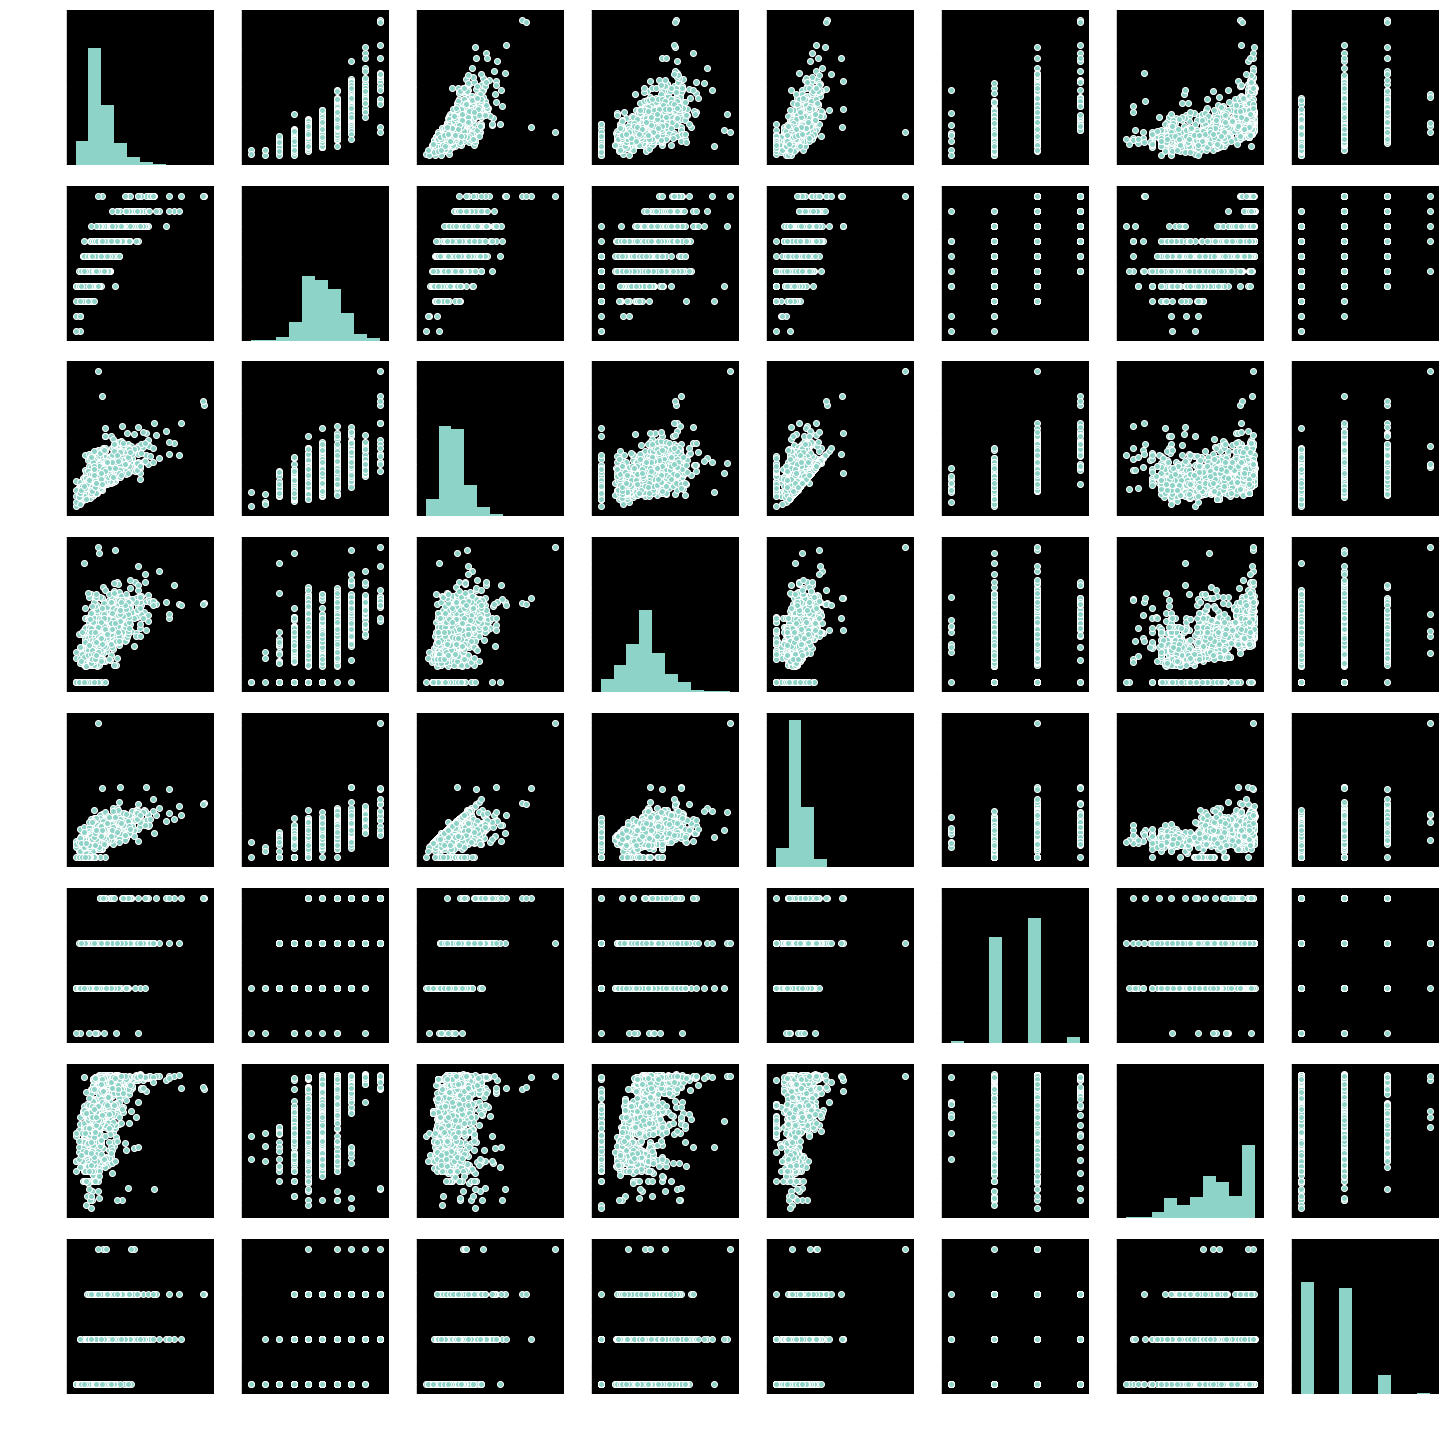

In [17]:
# cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'MasVnrArea', 'Fireplaces']
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'Fireplaces']
sns.pairplot(df_train[cols], size = 2.5);

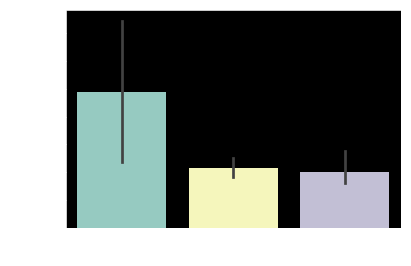

In [18]:
sns.barplot(x='PoolQC', y='SalePrice', data=df_train);

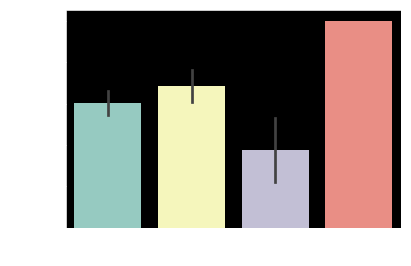

In [19]:
sns.barplot(x='MiscFeature', y='SalePrice', data=df_train);

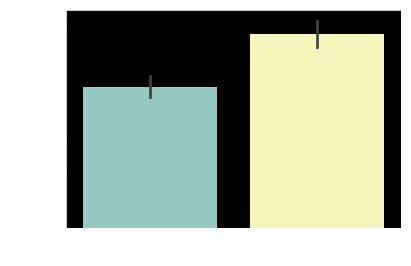

In [20]:
sns.barplot(x='Alley', y='SalePrice', data=df_train);

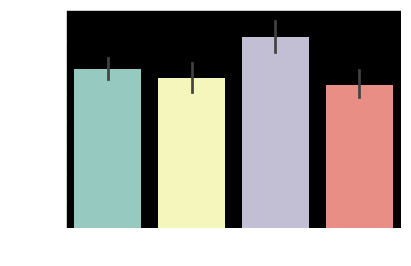

In [21]:
sns.barplot(x='Fence', y='SalePrice', data=df_train);

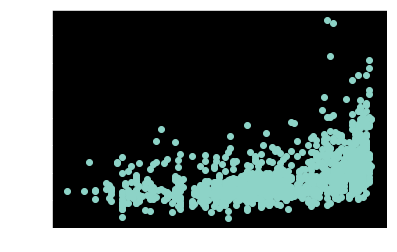

In [22]:
plt.scatter(x=df_train['GarageYrBlt'], y=df_train['SalePrice']);

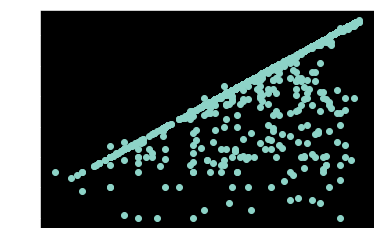

In [23]:
plt.scatter(x=df_train['GarageYrBlt'], y=df_train['YearBuilt']);

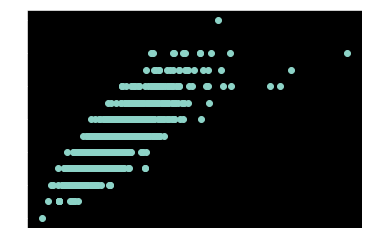

In [24]:
plt.scatter(x=df_train['GrLivArea'], y=df_train['TotRmsAbvGrd']);

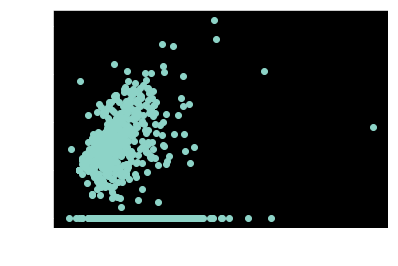

In [25]:
plt.scatter(x=df_train['1stFlrSF'], y=df_train['2ndFlrSF']);
plt.xlabel('1st floor area');
plt.ylabel('2nd floor area');

##  Counting Missing Values

In [26]:
count_mv = df_train.isnull().sum().sort_values(ascending = False)
percent_mv = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending = False)

missing_values = pd.concat([count_mv, percent_mv], axis=1, keys=['Total', 'Percent'])
missing_values.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


## Training and test sets

In [27]:
# data from train.csv
X = df_train.drop(columns = 'SalePrice')
y = df_train['SalePrice'].copy()

# data from test.csv
X_test = df_test.copy()

test_ID = X_test['Id']

In [28]:
# create training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=8)

#X_train.info()

In [29]:
# numerical features info
X_train_num = TypeSelector(np.number).fit_transform(X_train)
#X_train_num.info()

In [30]:
corrmat.loc['GarageYrBlt','GarageArea']

0.5645670607230588

In [31]:
corrmat.loc['GarageYrBlt','GarageCars']

0.5889200070047019

In [32]:
X_train_num.loc[X_train_num['GarageYrBlt'].isnull(), 
               ['GarageYrBlt', 'GarageCars', 'GarageArea']]

,GarageYrBlt,GarageCars,GarageArea
1173,NaN,0,0
1011,NaN,0,0
970,NaN,0,0
441,NaN,0,0
250,NaN,0,0
386,NaN,0,0
39,NaN,0,0
1219,NaN,0,0
1326,NaN,0,0
826,NaN,0,0


Analysing the previous table, we can conclude that the columns "GarageYrBlt" is highly correlated with column "GarageArea" and "GarageCars"

## Base Model

In [33]:
num_pipeline = make_pipeline(
    TypeSelector(np.number),
    Imputer(strategy = 'median'),
    StandardScaler()
)

X_train_model1 = num_pipeline.fit_transform(X_train)
X_val_model1 = num_pipeline.transform(X_val)
X_test_model1 = num_pipeline.transform(X_test)


In [34]:
lr = LinearRegression()
lr.fit(X_train_model1, y_train)
y_val_pred = lr.predict(X_val_model1)
print("RMSE for model 1:", 
      np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_pred = lr.predict(X_test_model1)

RMSE for model 1: 35380.40709727956


In [35]:
#y_pred

## Second Model with dropping columns with many missing values and GarageYrBlt

In [36]:
cols_to_drop = list(missing_values[missing_values['Percent'] > 0.15].index) + ['GarageYrBlt']


num_pipeline = make_pipeline(
    TypeSelector(np.number),
    DropColumns(cols_to_drop),
    Imputer(strategy = 'median'),
    StandardScaler()
)

X_train_model2 = num_pipeline.fit_transform(X_train)
X_val_model2 = num_pipeline.transform(X_val)
X_test_model2 = num_pipeline.transform(X_test)

In [37]:
lr = LinearRegression()
lr.fit(X_train_model2, y_train)
y_val_pred = lr.predict(X_val_model2)
print("RMSE for model 2:", 
      np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_pred = lr.predict(X_test_model2)

RMSE for model 2: 35006.33098401444


## Third Model with dropping highly correlated columns

In [38]:
# feature which says if the house has a 2nd floor
corrmat = df_train.corr()
corrmat_mask = corrmat['SalePrice'].abs().sort_values(ascending=True)

cols_to_drop = list(missing_values[missing_values['Percent'] > 0.15].index) \
+ list(corrmat_mask[corrmat_mask < 0.3].index) \
+ ['Id', 'GarageYrBlt', '2ndFlrSF', 'TotalBsmtSF', 'GarageCars', 
   'BsmtFullBath', 'BedroomAbvGr', 'YearRemodAdd']

num_pipeline = make_pipeline(
    TypeSelector(np.number),
    DropColumns(cols_to_drop),
    #FeatureEngineering(),
    Imputer(strategy = 'median'),
    StandardScaler()
)



X_train_model3 = num_pipeline.fit_transform(X_train)
X_val_model3 = num_pipeline.transform(X_val)
X_test_model3 = num_pipeline.transform(X_test)

#print(X_train_model2[1:2])

In [39]:
lr = LinearRegression()
lr.fit(X_train_model3, y_train)
y_val_pred = lr.predict(X_val_model3)
print("RMSE for model 3:", 
      np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_pred = lr.predict(X_test_model3)

RMSE for model 3: 35210.836033577216


## Fourth Model with categorical columns

In [40]:
# feature which says if the house has a 2nd floor
corrmat = df_train.corr()
corrmat_mask = corrmat['SalePrice'].abs().sort_values(ascending=True)

cols_to_drop = list(missing_values[missing_values['Percent'] > 0.15].index) \
+ list(corrmat_mask[corrmat_mask < 0.3].index) \
+ ['Id', 'GarageYrBlt', '2ndFlrSF', 'TotalBsmtSF', 'GarageCars', 
   'BsmtFullBath', 'BedroomAbvGr', 'YearRemodAdd']

num_pipeline = make_pipeline(
    TypeSelector(np.number),
    DropColumns(cols_to_drop),
    #FeatureEngineering(),
    Imputer(strategy = 'median'),
    StandardScaler()
)

cat_pipeline = make_pipeline(
    TypeSelector('object'),
    DropColumns(cols_to_drop),
    FillMissing(),
    ce.OneHotEncoder(handle_unknown='ignore')
)

union_pipeline = FeatureUnion(transformer_list = [
    ('numeric_pipeline', num_pipeline),
    ('categoric_pipeline', cat_pipeline)
])


X_train_model4 = union_pipeline.fit_transform(X_train)
X_val_model4 = union_pipeline.transform(X_val)
X_test_model4 = union_pipeline.transform(X_test)

#print(X_train_model4[1:2])

In [41]:
lr = LinearRegression()
lr.fit(X_train_model4, y_train)
y_val_pred = lr.predict(X_val_model4)
print("RMSE for model 4:", 
      np.sqrt(mean_squared_error(y_val, y_val_pred)))

y_pred = lr.predict(X_test_model4)

RMSE for model 4: 32328.3186216154


In [42]:
lr.coef_

array([ 9.61011570e+03,  4.82437593e+03,  4.29222767e+03,  8.77387703e+03,
       -1.02184389e+03,  4.03800808e+04,  1.12624582e+03, -5.59751005e+02,
        8.82806582e+02,  3.51835083e+03,  1.79088487e+03,  1.81457469e+03,
       -6.35852808e+14, -6.35852808e+14, -6.35852808e+14, -6.35852808e+14,
       -6.35852808e+14,  4.29259308e+14,  4.29259308e+14,  6.23270984e+14,
        6.23270984e+14,  6.23270984e+14,  6.23270984e+14,  7.19704014e+13,
        7.19704014e+13,  7.19704014e+13,  7.19704014e+13, -1.10898911e+14,
       -1.10898911e+14, -5.72146798e+12, -5.72146796e+12, -5.72146797e+12,
       -5.72146798e+12, -5.72146797e+12, -7.15360126e+14, -7.15360126e+14,
       -7.15360126e+14,  7.17364686e+14,  7.17364686e+14,  7.17364686e+14,
        7.17364686e+14,  7.17364686e+14,  7.17364686e+14,  7.17364686e+14,
        7.17364686e+14,  7.17364686e+14,  7.17364686e+14,  7.17364686e+14,
        7.17364686e+14,  7.17364686e+14,  7.17364686e+14,  7.17364686e+14,
        7.17364686e+14,  

In [43]:
Pipeline(num_pipeline.steps[0:2]).fit_transform(X_train).columns

Index(['OverallQual', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF'],
      dtype='object')

In [44]:
Pipeline(cat_pipeline.steps[0:4]).fit_transform(X_train).columns

Index(['MSZoning_1', 'MSZoning_2', 'MSZoning_3', 'MSZoning_4', 'MSZoning_5',
       'Street_1', 'Street_2', 'LotShape_1', 'LotShape_2', 'LotShape_3',
       ...
       'SaleType_6', 'SaleType_7', 'SaleType_8', 'SaleType_9',
       'SaleCondition_1', 'SaleCondition_2', 'SaleCondition_3',
       'SaleCondition_4', 'SaleCondition_5', 'SaleCondition_6'],
      dtype='object', length=234)

In [45]:
col_index = Pipeline(num_pipeline.steps[0:2]).fit_transform(X_train).columns.append(Pipeline(cat_pipeline.steps[0:4]).fit_transform(X_train).columns)

In [46]:
pd.Series(data=lr.coef_, index=col_index).nlargest(100)

MasVnrType_3      4.361858e+15
MasVnrType_2      4.361858e+15
MasVnrType_1      4.361858e+15
MasVnrType_4      4.361858e+15
Foundation_6      4.305352e+15
Foundation_1      4.305352e+15
Foundation_2      4.305352e+15
Foundation_3      4.305352e+15
Foundation_4      4.305352e+15
Foundation_5      4.305352e+15
KitchenQual_3     2.364950e+15
KitchenQual_2     2.364950e+15
KitchenQual_1     2.364950e+15
KitchenQual_4     2.364950e+15
BsmtQual_3        1.339405e+15
BsmtQual_4        1.339405e+15
BsmtQual_2        1.339405e+15
BsmtQual_1        1.339405e+15
BsmtFinType1_2    8.654867e+14
BsmtFinType1_3    8.654867e+14
BsmtFinType1_4    8.654867e+14
BsmtFinType1_1    8.654867e+14
BsmtFinType1_5    8.654867e+14
BsmtFinType1_6    8.654867e+14
RoofStyle_4       7.272237e+14
RoofStyle_5       7.272237e+14
RoofStyle_2       7.272237e+14
RoofStyle_1       7.272237e+14
RoofStyle_3       7.272237e+14
RoofStyle_6       7.272237e+14
                      ...     
BsmtFinType2_4    4.020361e+14
BsmtFinT

In [47]:
#Pipeline(num_pipeline.steps[0:2]).fit_transform(X_train)

In [48]:
#sns.barplot(x='2ndFlr', y=y_train, data=Pipeline(num_pipeline.steps[0:3]).fit_transform(X_train));

## Submission

In [53]:
predictions = pd.DataFrame({'Id': test_ID, 'SalePrice': y_pred})

In [54]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
Id           1459 non-null int64
SalePrice    1459 non-null float64
dtypes: float64(1), int64(1)
memory usage: 22.9 KB


In [55]:
predictions.head()

,Id,SalePrice
0,1461,109252.0
1,1462,168002.0
2,1463,182123.0
3,1464,186597.0
4,1465,198878.0


In [56]:
predictions.to_csv('submission.csv', index = False)